# Generating Data for CNN

In [4]:
# Manually annotating some timestamps with their labels

timestamps = [2.0, 13.0, 21.0, 23.0, 25.0, 27.0, 28.0, 31.0, 34.0, 54.0, 56.0, 60.0, 62.0, 63.0, 68.0, 75.0, 108.0, 118.0]
labels = ['play', 'play','play','non','non','non','non', 'non','play','play','play', 'non', 'non', 'non', 'non','non', 'play', 'play']

In [1]:
import os 
import cv2 
import csv

In [2]:
PATH_VIDEO = os.path.join('data','match2.mp4')
PATH_CSV = os.path.join('data','cnn','cnndata.csv')

In [11]:
fields = ['file', 'label']
with open(PATH_CSV, 'a') as csvfile:   
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(fields) 

In [12]:
# Generating frames 

def generateCNNData(timestamps, labels, file): 
    PATH_FRAMES = os.path.join('data','cnn','frames')
    video = cv2.VideoCapture(file) 
    fps = video.get(cv2.CAP_PROP_FPS)
    print('frames per second =',fps) 
    for i,second in enumerate(timestamps):
        frame_id = int(fps*float(second))
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_id) 
        success, frame = video.read() 
        if success:     
            framepath = os.path.join(PATH_FRAMES, f'frame{i}.jpg')
            cv2.imwrite(framepath, frame)
            print(f'Saved frame {i}')
        with open(PATH_CSV, 'a') as csvfile:   
            csvwriter = csv.writer(csvfile) 
            # writing the fields 
            csvwriter.writerow([framepath,labels[i]]) 
        

In [13]:
generateCNNData(timestamps,labels,PATH_VIDEO) 

frames per second = 30.0
Capturing frames for timestamp 0
	 Saved frame 0
Capturing frames for timestamp 1
	 Saved frame 1
Capturing frames for timestamp 2
	 Saved frame 2
Capturing frames for timestamp 3
	 Saved frame 3
Capturing frames for timestamp 4
	 Saved frame 4
Capturing frames for timestamp 5
	 Saved frame 5
Capturing frames for timestamp 6
	 Saved frame 6
Capturing frames for timestamp 7
	 Saved frame 7
Capturing frames for timestamp 8
	 Saved frame 8
Capturing frames for timestamp 9
	 Saved frame 9
Capturing frames for timestamp 10
	 Saved frame 10
Capturing frames for timestamp 11
	 Saved frame 11
Capturing frames for timestamp 12
	 Saved frame 12
Capturing frames for timestamp 13
	 Saved frame 13
Capturing frames for timestamp 14
	 Saved frame 14
Capturing frames for timestamp 15
	 Saved frame 15
Capturing frames for timestamp 16
	 Saved frame 16
Capturing frames for timestamp 17
	 Saved frame 17


## Loading Data and Preprocessing

In [3]:
import pandas as pd 
import os

df = pd.read_csv(PATH_CSV) 
df.head()

,file,label
0,data\cnn\frames\frame0.jpg,play
1,data\cnn\frames\frame1.jpg,play
2,data\cnn\frames\frame2.jpg,play
3,data\cnn\frames\frame3.jpg,non
4,data\cnn\frames\frame4.jpg,non


In [4]:
# Rescaling Images

from skimage import io 
from skimage.transform import rescale 
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 

urls = df['file'] 
X = [] 

le = preprocessing.LabelEncoder()
le.fit(df.label)
df['categorical_label'] = le.transform(df.label)

y = np.array(df['categorical_label']) 
y = tf.keras.utils.to_categorical(y ,num_classes=2)  

for url in urls: 
    img = io.imread(url, as_gray = True) 
    img = rescale(img, 0.1 , anti_aliasing = True) 
    img = img.reshape([img.shape[0],img.shape[1],1])
    X.append(img) 
    
df.head() 

,file,label,categorical_label
0,data\cnn\frames\frame0.jpg,play,1
1,data\cnn\frames\frame1.jpg,play,1
2,data\cnn\frames\frame2.jpg,play,1
3,data\cnn\frames\frame3.jpg,non,0
4,data\cnn\frames\frame4.jpg,non,0


In [5]:
X = np.array(X) 
X.shape

(18, 72, 128, 1)

In [6]:
y.shape

(18, 2)

## Train/Test Split

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3) 

# CNN Model Training

In [8]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=0) 
model = tf.keras.Sequential([
    # Add Convo Layers here 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', input_shape = [X.shape[1],X.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu'),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    # Add ANN here 
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 2, activation= 'softmax', kernel_initializer= xavier_init)  # Output Layer 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [9]:
model.fit(
    X_train, y_train, 
    batch_size=6, 
    epochs = 5, 
    verbose = 2, 
    validation_data=(X_test, y_test)
) 

Epoch 1/5
2/2 - 4s - loss: 0.9383 - accuracy: 0.4167 - val_loss: 0.5638 - val_accuracy: 1.0000 - 4s/epoch - 2s/step
Epoch 2/5
2/2 - 0s - loss: 0.5562 - accuracy: 0.8333 - val_loss: 0.5680 - val_accuracy: 0.6667 - 156ms/epoch - 78ms/step
Epoch 3/5
2/2 - 0s - loss: 0.4792 - accuracy: 0.8333 - val_loss: 0.3400 - val_accuracy: 1.0000 - 113ms/epoch - 56ms/step
Epoch 4/5
2/2 - 0s - loss: 0.2821 - accuracy: 1.0000 - val_loss: 0.2155 - val_accuracy: 1.0000 - 116ms/epoch - 58ms/step
Epoch 5/5
2/2 - 0s - loss: 0.1723 - accuracy: 1.0000 - val_loss: 0.1478 - val_accuracy: 1.0000 - 105ms/epoch - 52ms/step


# CNN Model Prediction Results

1/1 [==============================] - 0s 113ms/step
Prediction:  ['non']


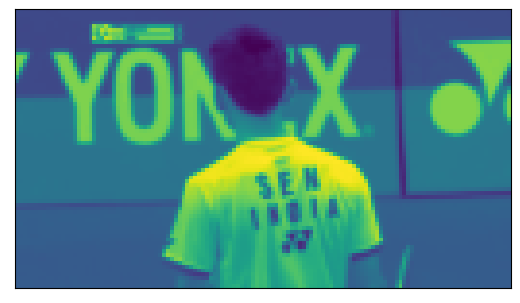

------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Prediction:  ['play']


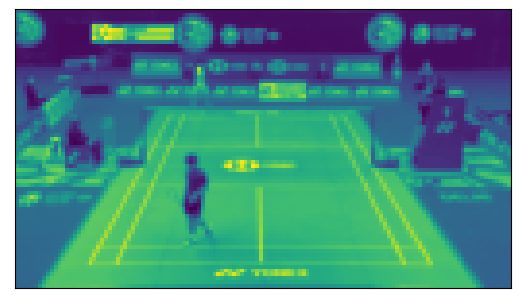

------------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Prediction:  ['play']


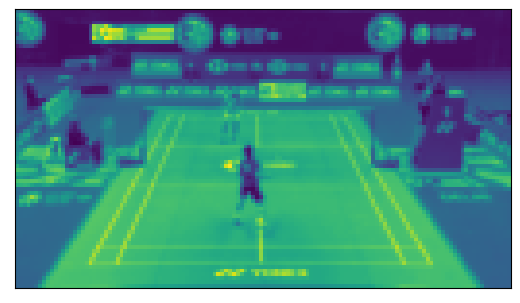

------------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Prediction:  ['non']


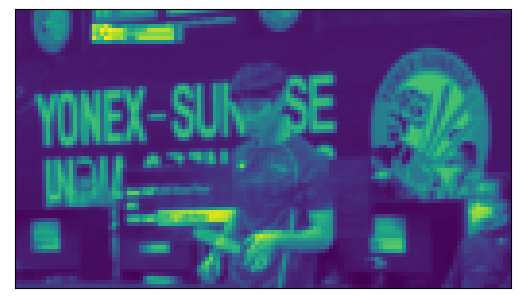

------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Prediction:  ['non']


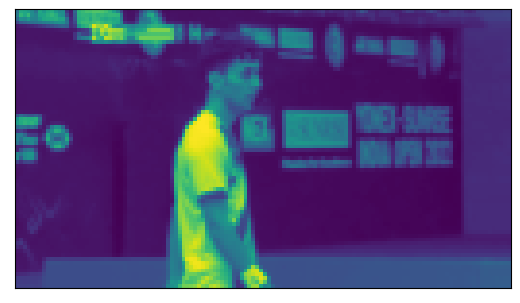

------------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Prediction:  ['non']


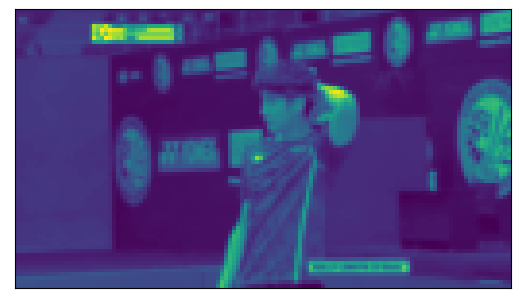

------------------------------------------------------------------


In [10]:
import matplotlib.pyplot as plt

for i in range(len(X_test)): 
    img = X_test[i].reshape([1,X.shape[1],X.shape[2],1])
    prediction = model.predict(img).argmax()
    print('Prediction: ', le.inverse_transform([prediction])) 
    plt.imshow(X_test[i]) 
    plt.xticks([]) 
    plt.yticks([])
    plt.show() 
    print('------------------------------------------------------------------')

# Model Results on Random Frames in the full video

In [11]:
from random import randint

def getRandomFrame(file_video): 
    video = cv2.VideoCapture(file_video) 
    fps = video.get(cv2.CAP_PROP_FPS)
    n = randint(0, 300)
    frame_id = int(fps*float(n)) 
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id) 
    success, frame = video.read()
    if success:     
        return frame 

In [12]:
from tensorflow.keras.models import load_model 
from skimage.color import rgb2gray 
from skimage.transform import rescale 

def get_frame_type(frame): 
    img = rgb2gray(frame) 
    img = rescale(img, 0.1 , anti_aliasing = True) 
    img = img.reshape([1,img.shape[0],img.shape[1],1]) 
    return model.predict(img, verbose=0).argmax(), img

Prediction:  ['play']


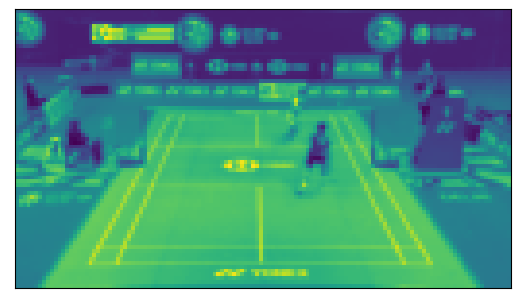

In [13]:
from skimage.color import rgb2gray 

img = getRandomFrame(PATH_VIDEO) 
prediction, img = get_frame_type(img) 
print('Prediction: ', le.inverse_transform([prediction])) 
plt.imshow(img[0]) 
plt.xticks([]) 
plt.yticks([])
plt.show() 

Works well!!

# Saving Model

In [14]:
PATH_MODEL = os.path.join('data','cnn','model.h5')
model.save(PATH_MODEL)

# Creating Timestamps of all non-play frames

In [15]:
def writeFrameID(frame_id,PATH_FRAME_TIMESTAMPS): 
    
    with open(PATH_FRAME_TIMESTAMPS, 'a+') as f: 
        f.seek(0) 
        timestamps = f.read().split(',') 
        if not (len(timestamps) == 1 and timestamps[0] == ''): 
            f.write(',' + str(frame_id))
            print(f'Added frame id {frame_id} to file')
        else: 
            f.write(str(frame_id))
            print(f'Added frame id {frame_id} to file')

In [16]:
def createFrameIDs(file_video, PATH_FRAME_TIMESTAMPS): 
    video = cv2.VideoCapture(file_video) 
    fps = video.get(cv2.CAP_PROP_FPS)
    frames = video.get(cv2.CAP_PROP_FRAME_COUNT) 
    for i in range(int(frames)): 
        video.set(cv2.CAP_PROP_POS_FRAMES, i) 
        success, frame = video.read() 
        if success:     
            if get_frame_type(frame)[0] == 0: 
                writeFrameID(i,PATH_FRAME_TIMESTAMPS) 

In [18]:
PATH_FRAME_TIMESTAMPS = os.path.join('data','cnn','frame_timestamps.txt')
createFrameIDs(PATH_VIDEO, PATH_FRAME_TIMESTAMPS)

Added frame id 666 to file
Added frame id 667 to file
Added frame id 668 to file
Added frame id 669 to file
Added frame id 670 to file
Added frame id 671 to file
Added frame id 672 to file
Added frame id 673 to file
Added frame id 674 to file
Added frame id 675 to file
Added frame id 676 to file
Added frame id 677 to file
Added frame id 678 to file
Added frame id 679 to file
Added frame id 680 to file
Added frame id 681 to file
Added frame id 682 to file
Added frame id 683 to file
Added frame id 684 to file
Added frame id 685 to file
Added frame id 686 to file
Added frame id 687 to file
Added frame id 688 to file
Added frame id 689 to file
Added frame id 690 to file
Added frame id 691 to file
Added frame id 692 to file
Added frame id 693 to file
Added frame id 694 to file
Added frame id 695 to file
Added frame id 696 to file
Added frame id 697 to file
Added frame id 698 to file
Added frame id 699 to file
Added frame id 700 to file
Added frame id 701 to file
Added frame id 702 to file
A

Added frame id 970 to file
Added frame id 971 to file
Added frame id 972 to file
Added frame id 973 to file
Added frame id 974 to file
Added frame id 975 to file
Added frame id 1749 to file
Added frame id 1750 to file
Added frame id 1751 to file
Added frame id 1752 to file
Added frame id 1753 to file
Added frame id 1754 to file
Added frame id 1755 to file
Added frame id 1756 to file
Added frame id 1757 to file
Added frame id 1758 to file
Added frame id 1759 to file
Added frame id 1760 to file
Added frame id 1761 to file
Added frame id 1762 to file
Added frame id 1763 to file
Added frame id 1764 to file
Added frame id 1765 to file
Added frame id 1766 to file
Added frame id 1767 to file
Added frame id 1768 to file
Added frame id 1769 to file
Added frame id 1770 to file
Added frame id 1771 to file
Added frame id 1772 to file
Added frame id 1773 to file
Added frame id 1774 to file
Added frame id 1775 to file
Added frame id 1776 to file
Added frame id 1777 to file
Added frame id 1778 to fil

Added frame id 2037 to file
Added frame id 2038 to file
Added frame id 2039 to file
Added frame id 2040 to file
Added frame id 2041 to file
Added frame id 2042 to file
Added frame id 2043 to file
Added frame id 2044 to file
Added frame id 2045 to file
Added frame id 2046 to file
Added frame id 2047 to file
Added frame id 2048 to file
Added frame id 2049 to file
Added frame id 2050 to file
Added frame id 2051 to file
Added frame id 2052 to file
Added frame id 2053 to file
Added frame id 2054 to file
Added frame id 2055 to file
Added frame id 2056 to file
Added frame id 2057 to file
Added frame id 2058 to file
Added frame id 2059 to file
Added frame id 2060 to file
Added frame id 2061 to file
Added frame id 2062 to file
Added frame id 2063 to file
Added frame id 2064 to file
Added frame id 2065 to file
Added frame id 2066 to file
Added frame id 2067 to file
Added frame id 2068 to file
Added frame id 2069 to file
Added frame id 2070 to file
Added frame id 2071 to file
Added frame id 2072 

Added frame id 2330 to file
Added frame id 2331 to file
Added frame id 2332 to file
Added frame id 2333 to file
Added frame id 2334 to file
Added frame id 2335 to file
Added frame id 2336 to file
Added frame id 2337 to file
Added frame id 2338 to file
Added frame id 2339 to file
Added frame id 2340 to file
Added frame id 2341 to file
Added frame id 2342 to file
Added frame id 2343 to file
Added frame id 2344 to file
Added frame id 2345 to file
Added frame id 2346 to file
Added frame id 2347 to file
Added frame id 2348 to file
Added frame id 2349 to file
Added frame id 2350 to file
Added frame id 2351 to file
Added frame id 2352 to file
Added frame id 2353 to file
Added frame id 2354 to file
Added frame id 2355 to file
Added frame id 2356 to file
Added frame id 2357 to file
Added frame id 2358 to file
Added frame id 2359 to file
Added frame id 2360 to file
Added frame id 2361 to file
Added frame id 2362 to file
Added frame id 2363 to file
Added frame id 2364 to file
Added frame id 2365 

Added frame id 2864 to file
Added frame id 2865 to file
Added frame id 2866 to file
Added frame id 2867 to file
Added frame id 2868 to file
Added frame id 2869 to file
Added frame id 2870 to file
Added frame id 2871 to file
Added frame id 2872 to file
Added frame id 2873 to file
Added frame id 2874 to file
Added frame id 2875 to file
Added frame id 2876 to file
Added frame id 2877 to file
Added frame id 2878 to file
Added frame id 2879 to file
Added frame id 2880 to file
Added frame id 2881 to file
Added frame id 2882 to file
Added frame id 2883 to file
Added frame id 2884 to file
Added frame id 2885 to file
Added frame id 2886 to file
Added frame id 2887 to file
Added frame id 2888 to file
Added frame id 2889 to file
Added frame id 2890 to file
Added frame id 2891 to file
Added frame id 2892 to file
Added frame id 2893 to file
Added frame id 2894 to file
Added frame id 2895 to file
Added frame id 2896 to file
Added frame id 2897 to file
Added frame id 2898 to file
Added frame id 2899 

Added frame id 4034 to file
Added frame id 4035 to file
Added frame id 4036 to file
Added frame id 4037 to file
Added frame id 4038 to file
Added frame id 4039 to file
Added frame id 4040 to file
Added frame id 4041 to file
Added frame id 4042 to file
Added frame id 4043 to file
Added frame id 4044 to file
Added frame id 4045 to file
Added frame id 4046 to file
Added frame id 4047 to file
Added frame id 4048 to file
Added frame id 4049 to file
Added frame id 4050 to file
Added frame id 4051 to file
Added frame id 4052 to file
Added frame id 4053 to file
Added frame id 4054 to file
Added frame id 4055 to file
Added frame id 4056 to file
Added frame id 4057 to file
Added frame id 4058 to file
Added frame id 4059 to file
Added frame id 4060 to file
Added frame id 4061 to file
Added frame id 4062 to file
Added frame id 4063 to file
Added frame id 4064 to file
Added frame id 4065 to file
Added frame id 4066 to file
Added frame id 4067 to file
Added frame id 4068 to file
Added frame id 4069 

Added frame id 4328 to file
Added frame id 4329 to file
Added frame id 4330 to file
Added frame id 4331 to file
Added frame id 4332 to file
Added frame id 4333 to file
Added frame id 4334 to file
Added frame id 4335 to file
Added frame id 4336 to file
Added frame id 4337 to file
Added frame id 4338 to file
Added frame id 4339 to file
Added frame id 4340 to file
Added frame id 4341 to file
Added frame id 4342 to file
Added frame id 4343 to file
Added frame id 4344 to file
Added frame id 4345 to file
Added frame id 4346 to file
Added frame id 4347 to file
Added frame id 4348 to file
Added frame id 4349 to file
Added frame id 4350 to file
Added frame id 4351 to file
Added frame id 4352 to file
Added frame id 4353 to file
Added frame id 4354 to file
Added frame id 4355 to file
Added frame id 4356 to file
Added frame id 4357 to file
Added frame id 4358 to file
Added frame id 4359 to file
Added frame id 4360 to file
Added frame id 4361 to file
Added frame id 4362 to file
Added frame id 4363 

Added frame id 4802 to file
Added frame id 4803 to file
Added frame id 4804 to file
Added frame id 4805 to file
Added frame id 4806 to file
Added frame id 4807 to file
Added frame id 4808 to file
Added frame id 4809 to file
Added frame id 4810 to file
Added frame id 4811 to file
Added frame id 4812 to file
Added frame id 4813 to file
Added frame id 4814 to file
Added frame id 4815 to file
Added frame id 4816 to file
Added frame id 4817 to file
Added frame id 4818 to file
Added frame id 4819 to file
Added frame id 4820 to file
Added frame id 4821 to file
Added frame id 4822 to file
Added frame id 4823 to file
Added frame id 4824 to file
Added frame id 4825 to file
Added frame id 4826 to file
Added frame id 4827 to file
Added frame id 4828 to file
Added frame id 4829 to file
Added frame id 4830 to file
Added frame id 4831 to file
Added frame id 4832 to file
Added frame id 4833 to file
Added frame id 4834 to file
Added frame id 4835 to file
Added frame id 4836 to file
Added frame id 4837 

Added frame id 5431 to file
Added frame id 5432 to file
Added frame id 5433 to file
Added frame id 5434 to file
Added frame id 5435 to file
Added frame id 5436 to file
Added frame id 5437 to file
Added frame id 5438 to file
Added frame id 5439 to file
Added frame id 5440 to file
Added frame id 5441 to file
Added frame id 5442 to file
Added frame id 5443 to file
Added frame id 5444 to file
Added frame id 5445 to file
Added frame id 5446 to file
Added frame id 5447 to file
Added frame id 5448 to file
Added frame id 5449 to file
Added frame id 5450 to file
Added frame id 5451 to file
Added frame id 5452 to file
Added frame id 5453 to file
Added frame id 5454 to file
Added frame id 5455 to file
Added frame id 5456 to file
Added frame id 5457 to file
Added frame id 5458 to file
Added frame id 5459 to file
Added frame id 5460 to file
Added frame id 5461 to file
Added frame id 5462 to file
Added frame id 5463 to file
Added frame id 5464 to file
Added frame id 5465 to file
Added frame id 5466 

Added frame id 5963 to file
Added frame id 5964 to file
Added frame id 5965 to file
Added frame id 5966 to file
Added frame id 5967 to file
Added frame id 5968 to file
Added frame id 5969 to file
Added frame id 5970 to file
Added frame id 5971 to file
Added frame id 5972 to file
Added frame id 5973 to file
Added frame id 5974 to file
Added frame id 5975 to file
Added frame id 5976 to file
Added frame id 5977 to file
Added frame id 5978 to file
Added frame id 5979 to file
Added frame id 5980 to file
Added frame id 5981 to file
Added frame id 5982 to file
Added frame id 5983 to file
Added frame id 5984 to file
Added frame id 5985 to file
Added frame id 5986 to file
Added frame id 5987 to file
Added frame id 5988 to file
Added frame id 5989 to file
Added frame id 5990 to file
Added frame id 5991 to file
Added frame id 5992 to file
Added frame id 5993 to file
Added frame id 5994 to file
Added frame id 5995 to file
Added frame id 5996 to file
Added frame id 5997 to file
Added frame id 5998 

Added frame id 6280 to file
Added frame id 6281 to file
Added frame id 6282 to file
Added frame id 6283 to file
Added frame id 6284 to file
Added frame id 6285 to file
Added frame id 6286 to file
Added frame id 6287 to file
Added frame id 6288 to file
Added frame id 6289 to file
Added frame id 6290 to file
Added frame id 6291 to file
Added frame id 6292 to file
Added frame id 6293 to file
Added frame id 6294 to file
Added frame id 6295 to file
Added frame id 6296 to file
Added frame id 6297 to file
Added frame id 6298 to file
Added frame id 6299 to file
Added frame id 6300 to file
Added frame id 6301 to file
Added frame id 6302 to file
Added frame id 6303 to file
Added frame id 6304 to file
Added frame id 6305 to file
Added frame id 6306 to file
Added frame id 6307 to file
Added frame id 6308 to file
Added frame id 6309 to file
Added frame id 6310 to file
Added frame id 6311 to file
Added frame id 6312 to file
Added frame id 6313 to file
Added frame id 6314 to file
Added frame id 6315 

Added frame id 6577 to file
Added frame id 6578 to file
Added frame id 6579 to file
Added frame id 6580 to file
Added frame id 6581 to file
Added frame id 6582 to file
Added frame id 6583 to file
Added frame id 6584 to file
Added frame id 6585 to file
Added frame id 6586 to file
Added frame id 6587 to file
Added frame id 6588 to file
Added frame id 6589 to file
Added frame id 6590 to file
Added frame id 6591 to file
Added frame id 6592 to file
Added frame id 6593 to file
Added frame id 6594 to file
Added frame id 6595 to file
Added frame id 6596 to file
Added frame id 6597 to file
Added frame id 6598 to file
Added frame id 6599 to file
Added frame id 6600 to file
Added frame id 6601 to file
Added frame id 6602 to file
Added frame id 6603 to file
Added frame id 6604 to file
Added frame id 6605 to file
Added frame id 6606 to file
Added frame id 6607 to file
Added frame id 6608 to file
Added frame id 6609 to file
Added frame id 6610 to file
Added frame id 6611 to file
Added frame id 6612 

Added frame id 7058 to file
Added frame id 7059 to file
Added frame id 7060 to file
Added frame id 7061 to file
Added frame id 7062 to file
Added frame id 7063 to file
Added frame id 7064 to file
Added frame id 7065 to file
Added frame id 7066 to file
Added frame id 7067 to file
Added frame id 7436 to file
Added frame id 7437 to file
Added frame id 7438 to file
Added frame id 7439 to file
Added frame id 7440 to file
Added frame id 7441 to file
Added frame id 7442 to file
Added frame id 7443 to file
Added frame id 7444 to file
Added frame id 7445 to file
Added frame id 7446 to file
Added frame id 7447 to file
Added frame id 7448 to file
Added frame id 7449 to file
Added frame id 7450 to file
Added frame id 7451 to file
Added frame id 7452 to file
Added frame id 7453 to file
Added frame id 7454 to file
Added frame id 7455 to file
Added frame id 7456 to file
Added frame id 7457 to file
Added frame id 7458 to file
Added frame id 7459 to file
Added frame id 7460 to file
Added frame id 7461 

Added frame id 7720 to file
Added frame id 7721 to file
Added frame id 7722 to file
Added frame id 7723 to file
Added frame id 7724 to file
Added frame id 7725 to file
Added frame id 7726 to file
Added frame id 7727 to file
Added frame id 7728 to file
Added frame id 7729 to file
Added frame id 7730 to file
Added frame id 7731 to file
Added frame id 7732 to file
Added frame id 7733 to file
Added frame id 7734 to file
Added frame id 7735 to file
Added frame id 7736 to file
Added frame id 7737 to file
Added frame id 7738 to file
Added frame id 7739 to file
Added frame id 7740 to file
Added frame id 7741 to file
Added frame id 7742 to file
Added frame id 7743 to file
Added frame id 7744 to file
Added frame id 7745 to file
Added frame id 7746 to file
Added frame id 7747 to file
Added frame id 7748 to file
Added frame id 7749 to file
Added frame id 7750 to file
Added frame id 7751 to file
Added frame id 7752 to file
Added frame id 7753 to file
Added frame id 7754 to file
Added frame id 7755 

Added frame id 8195 to file
Added frame id 8196 to file
Added frame id 8197 to file
Added frame id 8198 to file
Added frame id 8199 to file
Added frame id 8200 to file
Added frame id 8201 to file
Added frame id 8202 to file
Added frame id 8203 to file
Added frame id 8204 to file
Added frame id 8205 to file
Added frame id 8206 to file
Added frame id 8207 to file
Added frame id 8208 to file
Added frame id 8209 to file
Added frame id 8210 to file
Added frame id 8211 to file
Added frame id 8212 to file
Added frame id 8213 to file
Added frame id 8214 to file
Added frame id 8215 to file
Added frame id 8216 to file
Added frame id 8217 to file
Added frame id 8218 to file
Added frame id 8219 to file
Added frame id 8220 to file
Added frame id 8221 to file
Added frame id 8222 to file
Added frame id 8223 to file
Added frame id 8224 to file
Added frame id 8225 to file
Added frame id 8226 to file
Added frame id 8227 to file
Added frame id 8228 to file
Added frame id 8229 to file
Added frame id 8230 

Added frame id 9670 to file
Added frame id 9671 to file
Added frame id 9672 to file
Added frame id 9673 to file
Added frame id 9674 to file
Added frame id 9675 to file
Added frame id 9676 to file
Added frame id 9677 to file
Added frame id 9678 to file
Added frame id 9679 to file
Added frame id 9680 to file
Added frame id 9681 to file
Added frame id 9682 to file
Added frame id 9683 to file
Added frame id 9684 to file
Added frame id 9685 to file
Added frame id 9686 to file
Added frame id 9687 to file
Added frame id 9688 to file
Added frame id 9689 to file
Added frame id 9690 to file
Added frame id 9691 to file
Added frame id 9692 to file
Added frame id 9693 to file
Added frame id 9694 to file
Added frame id 9695 to file
Added frame id 9696 to file
Added frame id 9697 to file
Added frame id 9698 to file
Added frame id 9699 to file
Added frame id 9700 to file
Added frame id 9701 to file
Added frame id 9702 to file
Added frame id 9703 to file
Added frame id 9704 to file
Added frame id 9705 

Added frame id 10009 to file
Added frame id 10010 to file
Added frame id 10011 to file
Added frame id 10012 to file
Added frame id 10013 to file
Added frame id 10014 to file
Added frame id 10015 to file
Added frame id 10016 to file
Added frame id 10017 to file
Added frame id 10018 to file
Added frame id 10019 to file
Added frame id 10020 to file
Added frame id 10021 to file
Added frame id 10022 to file
Added frame id 10023 to file
Added frame id 10024 to file
Added frame id 10025 to file
Added frame id 10026 to file
Added frame id 10027 to file
Added frame id 10028 to file
Added frame id 10029 to file
Added frame id 10030 to file
Added frame id 10031 to file
Added frame id 10032 to file
Added frame id 10033 to file
Added frame id 10034 to file
Added frame id 10035 to file
Added frame id 10036 to file
Added frame id 10037 to file
Added frame id 10038 to file
Added frame id 10039 to file
Added frame id 10040 to file
Added frame id 10041 to file
Added frame id 10042 to file
Added frame id

Added frame id 10293 to file
Added frame id 10294 to file
Added frame id 10295 to file
Added frame id 10296 to file
Added frame id 10297 to file
Added frame id 10298 to file
Added frame id 10299 to file
Added frame id 10300 to file
Added frame id 10301 to file
Added frame id 10302 to file
Added frame id 10303 to file
Added frame id 10304 to file
Added frame id 10305 to file
Added frame id 10306 to file
Added frame id 10307 to file
Added frame id 10308 to file
Added frame id 10309 to file
Added frame id 10310 to file
Added frame id 10311 to file
Added frame id 10312 to file
Added frame id 10313 to file
Added frame id 10314 to file
Added frame id 10315 to file
Added frame id 10316 to file
Added frame id 10317 to file
Added frame id 10318 to file
Added frame id 10319 to file
Added frame id 10320 to file
Added frame id 10321 to file
Added frame id 10322 to file
Added frame id 10323 to file
Added frame id 10324 to file
Added frame id 10325 to file
Added frame id 10326 to file
Added frame id

Added frame id 10584 to file
Added frame id 10585 to file
Added frame id 10586 to file
Added frame id 10587 to file
Added frame id 10588 to file
Added frame id 10589 to file
Added frame id 10590 to file
Added frame id 10591 to file
Added frame id 10592 to file
Added frame id 10593 to file
Added frame id 10594 to file
Added frame id 10595 to file
Added frame id 10596 to file
Added frame id 10597 to file
Added frame id 10598 to file
Added frame id 10599 to file
Added frame id 10600 to file
Added frame id 10601 to file
Added frame id 10602 to file
Added frame id 10603 to file
Added frame id 10604 to file
Added frame id 10605 to file
Added frame id 10606 to file
Added frame id 10607 to file
Added frame id 10608 to file
Added frame id 10609 to file
Added frame id 10610 to file
Added frame id 10611 to file
Added frame id 10612 to file
Added frame id 10613 to file
Added frame id 10614 to file
Added frame id 10615 to file
Added frame id 10616 to file
Added frame id 10617 to file
Added frame id

Added frame id 10870 to file
Added frame id 10871 to file
Added frame id 10872 to file
Added frame id 10873 to file
Added frame id 10874 to file
Added frame id 10875 to file
Added frame id 10876 to file
Added frame id 10877 to file
Added frame id 10878 to file
Added frame id 10879 to file
Added frame id 10880 to file
Added frame id 10881 to file
Added frame id 10882 to file
Added frame id 10883 to file
Added frame id 10884 to file
Added frame id 10885 to file
Added frame id 10886 to file
Added frame id 10887 to file
Added frame id 10888 to file
Added frame id 10889 to file
Added frame id 10890 to file
Added frame id 10891 to file
Added frame id 10892 to file
Added frame id 10893 to file
Added frame id 10894 to file
Added frame id 10895 to file
Added frame id 10896 to file
Added frame id 10897 to file
Added frame id 10898 to file
Added frame id 10899 to file
Added frame id 10900 to file
Added frame id 10901 to file
Added frame id 10902 to file
Added frame id 10903 to file
Added frame id

Added frame id 11302 to file
Added frame id 11303 to file
Added frame id 11304 to file
Added frame id 11305 to file
Added frame id 11306 to file
Added frame id 11307 to file
Added frame id 11308 to file
Added frame id 11309 to file
Added frame id 11310 to file
Added frame id 11311 to file
Added frame id 11312 to file
Added frame id 11313 to file
Added frame id 11314 to file
Added frame id 11315 to file
Added frame id 11316 to file
Added frame id 11317 to file
Added frame id 11318 to file
Added frame id 11319 to file
Added frame id 11320 to file
Added frame id 11321 to file
Added frame id 11322 to file
Added frame id 11323 to file
Added frame id 11324 to file
Added frame id 11325 to file
Added frame id 11326 to file
Added frame id 11327 to file
Added frame id 11328 to file
Added frame id 11329 to file
Added frame id 11330 to file
Added frame id 11331 to file
Added frame id 11332 to file
Added frame id 11333 to file
Added frame id 11334 to file
Added frame id 11335 to file
Added frame id

Added frame id 11738 to file
Added frame id 11739 to file
Added frame id 11740 to file
Added frame id 11741 to file
Added frame id 11742 to file
Added frame id 11743 to file
Added frame id 11744 to file
Added frame id 11745 to file
Added frame id 11746 to file
Added frame id 11747 to file
Added frame id 11748 to file
Added frame id 11749 to file
Added frame id 11750 to file
Added frame id 11751 to file
Added frame id 11752 to file
Added frame id 11753 to file
Added frame id 11754 to file
Added frame id 11755 to file
Added frame id 11756 to file
Added frame id 11757 to file
Added frame id 11758 to file
Added frame id 11759 to file
Added frame id 11760 to file
Added frame id 11761 to file
Added frame id 11762 to file
Added frame id 11763 to file
Added frame id 11764 to file
Added frame id 11765 to file
Added frame id 11766 to file
Added frame id 11767 to file
Added frame id 11768 to file
Added frame id 11769 to file
Added frame id 11770 to file
Added frame id 11771 to file
Added frame id

Added frame id 12913 to file
Added frame id 12914 to file
Added frame id 12915 to file
Added frame id 12916 to file
Added frame id 12917 to file
Added frame id 12918 to file
Added frame id 12919 to file
Added frame id 12920 to file
Added frame id 12921 to file
Added frame id 12922 to file
Added frame id 12923 to file
Added frame id 12924 to file
Added frame id 12925 to file
Added frame id 12926 to file
Added frame id 12927 to file
Added frame id 12928 to file
Added frame id 12929 to file
Added frame id 12930 to file
Added frame id 12931 to file
Added frame id 12932 to file
Added frame id 12933 to file
Added frame id 12934 to file
Added frame id 12935 to file
Added frame id 12936 to file
Added frame id 12937 to file
Added frame id 12938 to file
Added frame id 12939 to file
Added frame id 12940 to file
Added frame id 12941 to file
Added frame id 12942 to file
Added frame id 12943 to file
Added frame id 12944 to file
Added frame id 12945 to file
Added frame id 12946 to file
Added frame id

Added frame id 13206 to file
Added frame id 13207 to file
Added frame id 13208 to file
Added frame id 13209 to file
Added frame id 13210 to file
Added frame id 13211 to file
Added frame id 13212 to file
Added frame id 13213 to file
Added frame id 13214 to file
Added frame id 13215 to file
Added frame id 13216 to file
Added frame id 13217 to file
Added frame id 13218 to file
Added frame id 13219 to file
Added frame id 13220 to file
Added frame id 13221 to file
Added frame id 13222 to file
Added frame id 13223 to file
Added frame id 13224 to file
Added frame id 13225 to file
Added frame id 13226 to file
Added frame id 13227 to file
Added frame id 13228 to file
Added frame id 13229 to file
Added frame id 13230 to file
Added frame id 13231 to file
Added frame id 13232 to file
Added frame id 13233 to file
Added frame id 13234 to file
Added frame id 13235 to file
Added frame id 13236 to file
Added frame id 13237 to file
Added frame id 13238 to file
Added frame id 13239 to file
Added frame id

Added frame id 13933 to file
Added frame id 13934 to file
Added frame id 13935 to file
Added frame id 13936 to file
Added frame id 13937 to file
Added frame id 13938 to file
Added frame id 13939 to file
Added frame id 13940 to file
Added frame id 13941 to file
Added frame id 13942 to file
Added frame id 13943 to file
Added frame id 13944 to file
Added frame id 13945 to file
Added frame id 13946 to file
Added frame id 13947 to file
Added frame id 13948 to file
Added frame id 13949 to file
Added frame id 13950 to file
Added frame id 13951 to file
Added frame id 13952 to file
Added frame id 13953 to file
Added frame id 13954 to file
Added frame id 13955 to file
Added frame id 13956 to file
Added frame id 13957 to file
Added frame id 13958 to file
Added frame id 13959 to file
Added frame id 13960 to file
Added frame id 13961 to file
Added frame id 13962 to file
Added frame id 13963 to file
Added frame id 13964 to file
Added frame id 13965 to file
Added frame id 13966 to file
Added frame id